In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.optimizers import Adam
from tensorflow.keras.layers import LSTM

In [6]:
# Loading the dataset from the 'train' directory

batch_size = 512
seed = 1337 # Keep the seed same for both 'train' & 'validation' to avoid overlap

train_ds = keras.preprocessing.text_dataset_from_directory(
    "../input/positionalembedding/hw2-ycbs-273-intro-to-prac-ml (1)/train", 
    batch_size=batch_size,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=seed)

val_ds = keras.preprocessing.text_dataset_from_directory(
    "../input/positionalembedding/hw2-ycbs-273-intro-to-prac-ml (1)/train",
    batch_size=batch_size,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=seed)

text_only_train_ds = train_ds.map(lambda x, y: x)

Found 120000 files belonging to 4 classes.
Using 96000 files for training.
Found 120000 files belonging to 4 classes.
Using 24000 files for validation.


In [7]:
from tensorflow.keras import layers

max_length = 50
max_tokens = 20000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
# int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))



In [8]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

In [11]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [12]:
#setting compile and learning rate
adam = Adam(lr = 3e-4)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 256)         5120000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                73984     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 5,194,244
Trainable params: 5,194,244
Non-trainable params: 0
_________________________________________________________________


In [13]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience = 5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="embeddings_bidir_gru_with_masking.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [14]:
model_history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=50, callbacks=callbacks_list)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_val_ds)[1]:.3f}")

Epoch 1/50
188/188 [==============================] - 305s 2s/step - loss: 0.8248 - accuracy: 0.7226 - val_loss: 0.2741 - val_accuracy: 0.9097
Epoch 2/50
188/188 [==============================] - 147s 753ms/step - loss: 0.2321 - accuracy: 0.9273 - val_loss: 0.2702 - val_accuracy: 0.9110
Epoch 3/50
188/188 [==============================] - 157s 805ms/step - loss: 0.1716 - accuracy: 0.9463 - val_loss: 0.2916 - val_accuracy: 0.9062
Epoch 4/50
188/188 [==============================] - 160s 825ms/step - loss: 0.1369 - accuracy: 0.9571 - val_loss: 0.3202 - val_accuracy: 0.9036
Epoch 5/50
188/188 [==============================] - 171s 881ms/step - loss: 0.1074 - accuracy: 0.9656 - val_loss: 0.3437 - val_accuracy: 0.9021
Epoch 6/50
188/188 [==============================] - 158s 813ms/step - loss: 0.0871 - accuracy: 0.9719 - val_loss: 0.3764 - val_accuracy: 0.9019
Epoch 7/50
47/47 [==============================] - 12s 187ms/step - loss: 0.2702 - accuracy: 0.9110
Test acc: 0.911


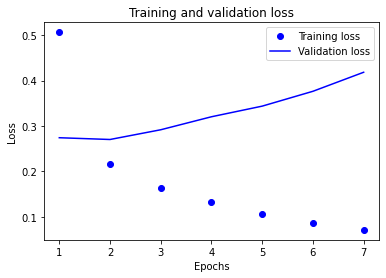

In [15]:
import matplotlib.pyplot as plt
#draw plot for visualization
history_dict = model_history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.show()

In [16]:
# Using the trained model to make prediction on unseen (test) data
# Here we use the 'adapted' text_vectorization layer and include it as part of a prediction_model

prediction_model = tf.keras.Sequential(
    [text_vectorization, model])

prediction_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `val_ds`, which yields raw strings
loss, accuracy = prediction_model.evaluate(val_ds)
print("Accuracy: {:2.2%}".format(accuracy))

47/47 [==============================] - 16s 195ms/step - loss: 0.2679 - accuracy: 0.9108
Accuracy: 91.10%


In [17]:
# Read the test data in the form of a dataframe

df_test_data = pd.read_csv('../input/positionalembedding/data_test_df.csv')
inputs = df_test_data['data']

In [18]:
# Make sure you use the 'prediction_model' and not the trained 'model' alone
# If you use the 'model' object, you will run int error as the data is still in the 'text' format and needs vectorization

predicted_scores = prediction_model.predict(inputs)
predicted_scores[0:5]

array([[2.3976955e-01, 2.5112671e-03, 6.8224269e-01, 7.5476542e-02],
       [5.6850999e-03, 4.3912613e-04, 6.2408452e-03, 9.8763496e-01],
       [5.9033041e-03, 5.3205749e-04, 2.7633721e-02, 9.6593082e-01],
       [7.5839167e-03, 1.2695008e-03, 4.5973431e-02, 9.4517314e-01],
       [1.3317887e-02, 5.2601646e-04, 8.8467393e-03, 9.7730941e-01]],
      dtype=float32)

In [19]:
# populating the dataframe to make a submission on Kaggle

df_predictions = pd.DataFrame(predicted_scores, columns=['solution_' + str(i+1) for i in range(4)])
df_predictions.index.rename('Id', inplace=True)

df_predictions.head(30)

,solution_1,solution_2,solution_3,solution_4
Id,,,,
0,0.239770,0.002511,0.682243,0.075477
1,0.005685,0.000439,0.006241,0.987635
2,0.005903,0.000532,0.027634,0.965931
3,0.007584,0.001270,0.045973,0.945173
4,0.013318,0.000526,0.008847,0.977309
5,0.005607,0.000568,0.007937,0.985888
6,0.031377,0.000517,0.005615,0.962492
7,0.006220,0.000508,0.007197,0.986076
8,0.010623,0.000895,0.032727,0.955755


In [ ]:
# If using colab, then download this and submit on Kaggle

df_predictions.to_csv('df_predictions_9.csv')